# 2. Model Development
Tahap ini digunakan untuk melakukan hyperparameter tuning, train-test, dan evaluasi performa model dengan menggunakan dataset yang telah dihasilkan pada tahap sebelumnya. Selain itu, algoritma yang digunakan adalah xgboost.

In [1]:
import os
import time
import joblib
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
# --- 1. CONFIGURATION ---
input_path = r'train-test dataset' # path of train-test dataset
raster_path = r'data\corrected\corrected_s2_giliketapang_2018-05-31.tif' # For feature names
output_path = r'model'
plot = r'model\plot' # Scatterplot

# Create output directories
os.makedirs(output_path, exist_ok=True)
os.makedirs(plot, exist_ok=True)


In [3]:
# --- 2. LOAD DATA ---
print("Loading datasets...")
# Using input_path variable
X_train = np.load(os.path.join(input_path, 'X_train.npy'))
X_test = np.load(os.path.join(input_path, 'X_test.npy'))
y_train = np.load(os.path.join(input_path, 'y_train.npy'))
y_test = np.load(os.path.join(input_path, 'y_test.npy'))

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Loading datasets...
Train shape: (737, 12), Test shape: (317, 12)


In [4]:
# Safety Check for NaNs
if np.isnan(X_train).sum() > 0 or np.isnan(y_train).sum() > 0:
    print("Warning: NaNs detected. Cleaning...")
    valid_mask = ~(np.isnan(X_train).any(axis=1) | np.isnan(y_train))
    X_train = X_train[valid_mask]
    y_train = y_train[valid_mask]
    

In [ ]:
# --- 3. HYPERPARAMETER TUNING ---
print("\n--- Starting Hyperparameter Tuning ---")

# Define search space
param_list = {
    'n_estimators': [50, 100, 300, 500, 1000],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# Initialize Base Model
xgb_base = XGBRegressor(
    random_state=42,
    tree_method='hist',
    device='cuda' if os.environ.get('CUDA_VISIBLE_DEVICES') else 'cpu'
)

# Setup Randomized Search
random_search = RandomizedSearchCV(
    xgb_base,
    param_list,
    scoring='neg_mean_squared_error',
    cv=10,
    n_iter=50,  # Number of random combinations to try
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Run Tuning
start_time = time.time()
random_search.fit(X_train, y_train)
print(f"Tuning completed in {time.time() - start_time:.2f} seconds")

# Get Best Model
best_xgb = random_search.best_estimator_
print("\nBest Parameters Found:", random_search.best_params_)



--- Starting Hyperparameter Tuning ---
Fitting 10 folds for each of 50 candidates, totalling 500 fits



--- Evaluating Model ---
Results for SDB Prediction:
  RMSE: 1.3741 m
  MAE:  0.9167 m
  R2:   0.9457
  Plot saved: model\plot\sdb_accuracy_plot.png


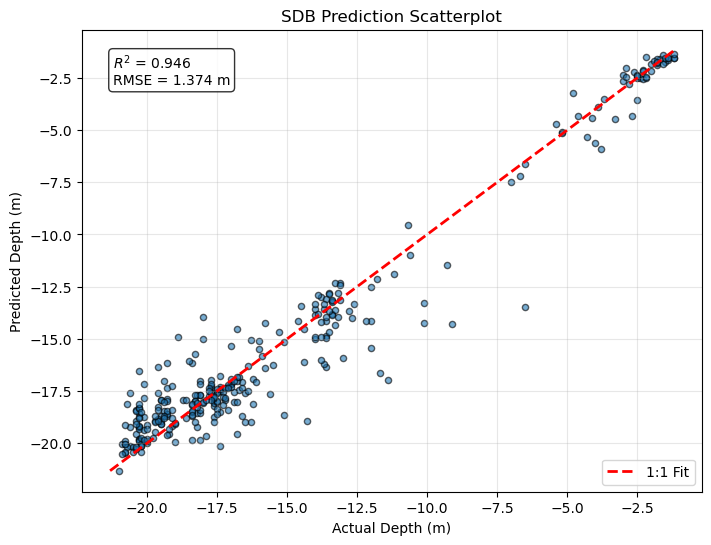

In [ ]:
# --- 4. EVALUATION ---
print("\n--- Evaluating Model ---")

def scatterplot(y_true, y_pred, title, filename):
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Results for {title}:")
    print(f"  RMSE: {rmse:.4f} m")
    print(f"  MAE:  {mae:.4f} m")
    print(f"  R2:   {r2:.4f}")

    # Create Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k', s=20)
    
    # Perfect 1:1 prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='1:1 Fit')
    
    plt.xlabel('Actual Depth (m)')
    plt.ylabel('Predicted Depth (m)')
    plt.title(f'{title} Scatterplot')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add metrics text box
    stats_text = f"$R^2$ = {r2:.3f}\nRMSE = {rmse:.3f} m"
    plt.gca().text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Save using the 'plot' directory variable
    save_path = os.path.join(plot, filename)
    plt.savefig(save_path, dpi=300)
    print(f"  Plot saved: {save_path}")
    plt.show()

# Predict on Test Set
y_pred = best_xgb.predict(X_test)
scatterplot(y_test, y_pred, "SDB Prediction", "sdb_accuracy_plot.png")



--- Generating Feature Importance ---
Feature importance saved: model\plot\feature_importance.png


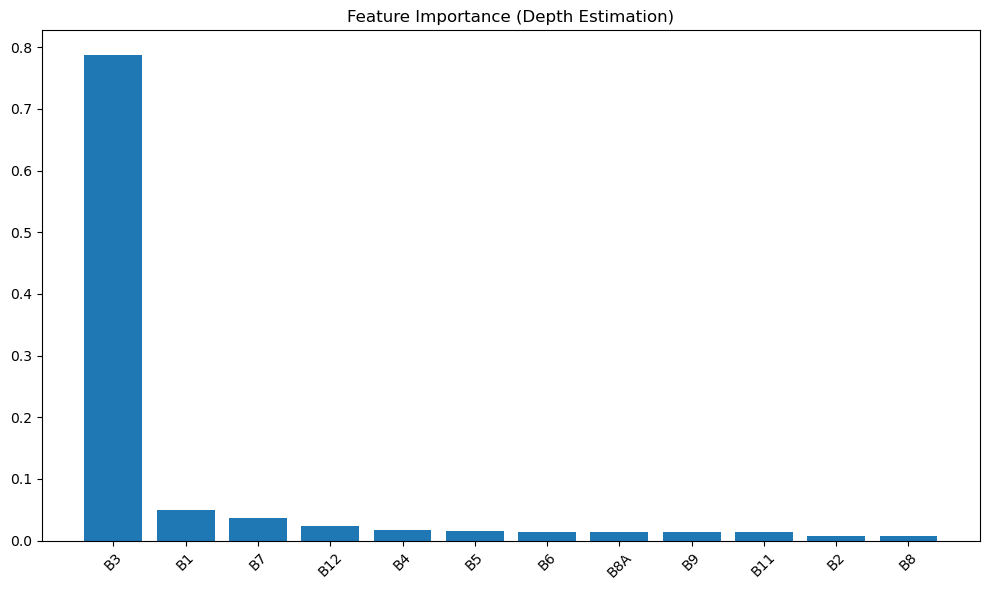

In [ ]:
# --- 5. FEATURE IMPORTANCE ---
print("\n--- Generating Feature Importance ---")

# Try to get band names from the 'raster_path' file
try:
    with rasterio.open(raster_path) as src:
        feature_names = list(src.descriptions)
        # If descriptions are empty/None, generate generic names
        if not any(feature_names): 
            feature_names = [f"Band_{i+1}" for i in range(src.count)]
except Exception as e:
    print(f"Could not read raster for feature names: {e}")
    feature_names = [f"Band_{i+1}" for i in range(X_train.shape[1])]

# Get importance from model
importance = best_xgb.feature_importances_
indices = np.argsort(importance)[::-1]

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Depth Estimation)")
plt.bar(range(len(importance)), importance[indices])
plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()

# Save to 'plot' directory
imp_save_path = os.path.join(plot, "feature_importance.png")
plt.savefig(imp_save_path, dpi=300)
print(f"Feature importance saved: {imp_save_path}")


In [ ]:
# --- 6. SAVE MODEL ---
model_filename = "xgboost_sdb_model.pkl"
# Save using 'output_path' variable
save_path = os.path.join(output_path, model_filename)
joblib.dump(best_xgb, save_path)

print("\n" + "="*40)
print(f"Model Training Complete! Saved to: {save_path}")
print("="*40)



Model Training Complete! Saved to: model\xgboost_sdb_model.pkl
